This script is somewhat similar to one of the other Jupyter notebooks. Rather than giving the oportunity to choose mass and metallicity, we here choose to keep either of the two fixed. We can then choose a position in the HR diagram. The script will find the closest model and print make the associated plots. The script can also produce an audio-file for the star in question.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import ipywidgets as widgets
from scipy.io import wavfile

coord = []

def amplitude(vmax,v0):
    sigma1 = 0.66*vmax**0.88
    a = np.exp(-(v0-vmax)**2/(2*sigma1**2))
    return a**2

def onclick(event):
    ix, iy = event.xdata, event.ydata
    global coord
    coord = [ix,iy]
    
def read_history(name):

    # Function to read history files from MESA
    
    dct = {}
    f = open(name)
    for i, line in enumerate(f):
        if i == 5:
            keys = line.split()
            break
    f.close()
    data = np.genfromtxt(name,skip_header=5)
    data= data[~np.isnan(data).any(axis=1)]
    
    for j, key in enumerate(keys):
        dct[key] = data[:,j]

    return dct    

# Function to read gyre output

def gyre_read(name):
    data = np.genfromtxt(name,skip_header=5)
    # See https://bitbucket.org/rhdtownsend/gyre/wiki/Output%20Files%20(5.0)
    l = data[:,0]
    n = data[:,2]
    v = data[:,4]
    I = data[:,7]

    mask0 = l == 0
    mask1 = l == 1
    mask2 = l == 2

    return l[mask0], n[mask0], v[mask0], I[mask0], l[mask1], n[mask1], v[mask1], I[mask1], l[mask2], n[mask2], v[mask2], I[mask2]

def echelle(name):
    l0, n0, v0, I0, l1, n1, v1, I1, l2, n2, v2, I2 = gyre_read(name)
    mdnu = np.mean(np.diff(v0))
    x0 = np.mod(v0,mdnu)
    x1 = np.mod(v1,mdnu)
    x2 = np.mod(v2,mdnu)
    return mdnu, x0, v0, x1, v1, x2, v2

Mass = []
FeH = []
where = []
with open("./OUTREACH_GRID/overview.txt") as f:
    lines = f.readlines()
    for line in lines:
        words = line.split()
        Mass.extend([float(words[0])])
        FeH.extend([float(words[1])])
        where.extend([words[2]])    

Mass = np.array(Mass)
FeH = np.array(FeH)
where = np.array(where)

In [2]:
whatconst = widgets.Select(
    options=['Metallicity', 'Mass'],
    value='Metallicity',
    # rows=10,
    description='Constant:',
    disabled=False
)
display(whatconst)

Select(description='Constant:', options=('Metallicity', 'Mass'), value='Metallicity')

In [3]:
if whatconst.value == "Metallicity":
    setFeH = widgets.FloatSlider(
    value=max(FeH)/2,
    min=min(FeH),
    max=max(FeH),
    step=0.1,
    description=r'$\mathrm{[Fe/H]}:$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    )
    display(setFeH)
else:
    setmass = widgets.FloatSlider(
    value=max(Mass)/2,
    min=min(Mass),
    max=max(Mass),
    step=0.1,
    description=r'$M/\mathrm{M}_\odot:$',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    )
    display(setmass)

FloatSlider(value=0.3757438507564905, description='$\\mathrm{[Fe/H]}:$', max=0.751487701512981, min=-2.8325486…

In [4]:
if whatconst.value == "Metallicity":
    mask = FeH <= setFeH.value + 0.1
    mask = np.logical_and(mask, FeH >= setFeH.value -0.1)
who = where[mask]

<IPython.core.display.Javascript object>


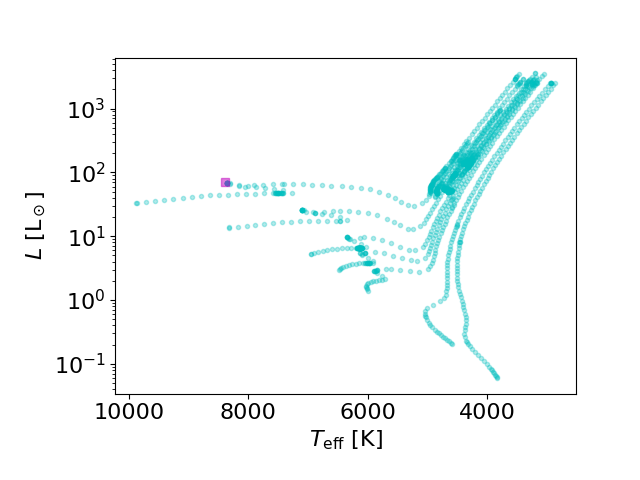

In [41]:
fig, ax = plt.subplots()
ax.set_xlabel(r'$T_\mathrm{eff} \,\, \mathrm{[K]}$',fontsize=16)
ax.set_ylabel(r'$L \,\, [\mathrm{L_\odot}]$',fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

plt.gcf().subplots_adjust(bottom=0.18)
plt.gcf().subplots_adjust(left=0.18)

TT = []
LL = []
II = []
for i, w in enumerate(who):
    dct = read_history(w+"LOGS/history.data")
    L = dct["luminosity"]
    Teff = dct["effective_T"]
    plt.semilogy(Teff,L,".",lw=2,color="c",alpha=0.3)
    TT.extend(list(Teff))
    LL.extend(list(L)) 
    II.extend(i*np.ones(len(L)))

ax.invert_xaxis()
cid = fig.canvas.mpl_connect('button_press_event', onclick)

<IPython.core.display.Javascript object>


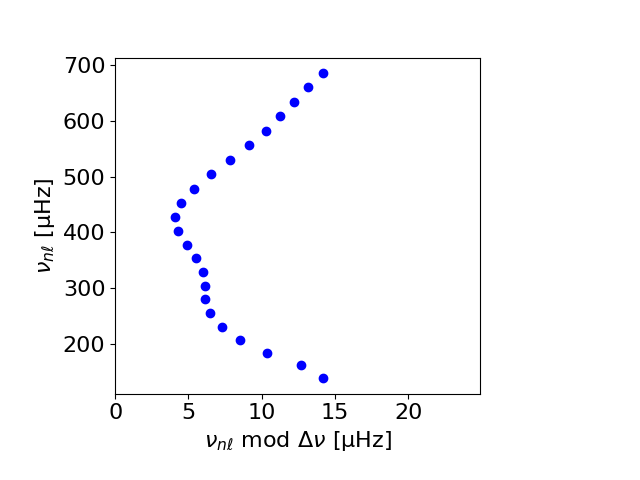

In [42]:
if coord:
    plt.plot(coord[0],coord[1],"ms",alpha=0.5)
    choice = who[int(II[((TT-coord[0])**2+(LL-coord[1])**2).argmin()])]
    dct = read_history(choice+"LOGS/history.data")
    nr = dct["model_number"]
    L = dct["luminosity"]
    Teff = dct["effective_T"]
    age = dct["star_age"]/1e6
    M = dct["star_mass"]
    R = dct["photosphere_r"]
    index = ((Teff-coord[0])**2+(L-coord[1])**2).argmin()
    Profiles = glob(choice+"LOGS/*.index")
    Profiles = np.genfromtxt(Profiles[0],skip_header=1)
    nrpr = Profiles[:,0]
    prof = Profiles[:,2]
    ef = [j for j, n in enumerate(nrpr) if n in nr]
    prof = prof[ef]
    prof[index]
    gyre_file = choice + "FREQS/" + choice[len("./OUTREACH_GRID/"):-1] + "_n" + str(int(prof[index])) + ".profile.FGONG.sgyre_l0"
    mdnu, x0, v0, x1, v1, x2, v2 = echelle(gyre_file)
    fig, ax = plt.subplots()
    plt.plot(x0, v0,"bo",label=r"$\ell = 0$")
    ax.set_xlim(0,mdnu)
    ax.set_xlabel(r"$\nu_{n\ell} \,\,\mathrm{mod}\,\,\Delta \nu\,\,\mathrm{[\mu Hz]}$",fontsize=16)
    ax.set_ylabel(r"$\nu_{n\ell}\,\,\mathrm{[\mu Hz]}$",fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)

    plt.gcf().subplots_adjust(bottom=0.18)
    plt.gcf().subplots_adjust(left=0.18)
    plt.gcf().subplots_adjust(right=0.75)
       
else:
    print("Select a point on the figure")
    

In [43]:
# The radial oscillations are translated into a wave-file.
if coord:
    vmax = 3090.*M[index]/R[index]**2/np.sqrt(Teff[index]/5777)
    l0, n0, v0, I0, l1, n1, v1, I1, l2, n2, v2, I2 = gyre_read(gyre_file)
    A = amplitude(vmax,v0)
    
    v0 = v0*330/vmax
    
    sampleRate = 44100
    t = np.linspace(0, 80, sampleRate * 20)  #  Produces a 5 second Audio-File
    v0 = v0
    y = A[-1]*np.sin(v0[-1]*t)
    for i,v in enumerate(v0[:-1]):
        ynew = A[i]*np.sin(v*t)
        y += ynew

    wav_name = "M"+str(round(M[index],1))+"_T"+str(round(Teff[index],0))+"_R"+str(round(R[index],1))+'.wav'
    wavfile.write(wav_name, sampleRate, y)    
